<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Kaggle Setup

In [0]:
!pip install -q kaggle
# get kaggle token
!wget -q https://www.dropbox.com/s/tyihc3nxt7pv5xd/kaggle.json
# Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Download Dataset

In [2]:
!kaggle datasets download -d camnugent/sandp500
!mkdir -p /content/stocks_data
!unzip -q -n /content/sandp500.zip -d /content/stocks_data/
!wget -q -nc https://datahub.io/core/s-and-p-500-companies-financials/r/constituents.csv
!ls

 26% 5.00M/19.3M [00:00<00:00, 29.4MB/s]
100% 19.3M/19.3M [00:00<00:00, 64.5MB/s]
constituents.csv  kaggle.json  sample_data  sandp500.zip  stocks_data


# Imports

In [0]:
import pandas as pd
import operator
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# Helper Functions

In [0]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [5]:
# Companies description
desc_df = pd.read_csv('/content/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('/content/stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [0]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This si something we will test out.

In [7]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

# Train Word Embeddings

In [0]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]

In [0]:
# train model
model = Word2Vec(stocks_w2v_data, min_count=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


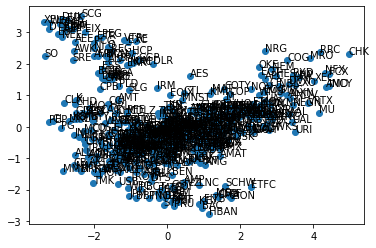

In [10]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [11]:
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: CNC	Name: Centene Corporation			Sector: Health Care
Symbol: MYL	Name: Mylan N.V.			Sector: Health Care
Symbol: BIIB	Name: Biogen Inc.			Sector: Health Care
Symbol: CELG	Name: Celgene Corp.			Sector: Health Care
Symbol: AAL	Name: American Airlines Group			Sector: Industrials
Symbol: TRIP	Name: TripAdvisor			Sector: Consumer Discretionary
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: UAA	Name: Under Armour Class A			Sector: Consumer Discretionary
Symbol: NFLX	Name: Netflix Inc.			Sector: Information Technology
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: AMD	Name: Advanced Micro Devices Inc			Sector: Information Technology
Symbol: UAL	Name: United

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [12]:
# access vector for one word
print(model['AAL'])

[ 0.56678    -0.01000427 -0.22827898 -0.08071941  0.05911825  0.2326646
 -0.31380478  0.731615   -0.6393346  -0.646412    0.6416601   0.17108244
  0.05771119  0.12541759  0.331366    0.65634346 -0.2212904  -0.6297441
  0.56465065 -0.15868287  0.46523952  0.15865792 -0.00432478 -0.38485056
 -0.3324434   0.19968405  0.56389856  0.04531314 -0.16761732  0.5409392
 -0.09588492  0.10022702  0.03401262 -0.68742895 -0.11486413 -0.255216
 -0.78402054 -0.91036993  0.3096064   0.35204878  0.17131858  0.46171933
 -0.18474016  0.32679066 -0.14167416  0.40192097  0.11374276 -0.41848788
 -0.9034975   0.14890894  0.3418293  -0.01283267 -0.2705165   0.04246625
 -0.01481463  0.13589408 -0.70852685  0.28832087 -0.574106    0.12333804
  0.183597   -0.15242323 -0.6969282   0.57124627  0.45734915 -0.04635176
  0.11021233  0.24504931  0.28002048  0.5455165   0.00560872  0.13870914
  0.22193362  0.1041666  -0.42079344 -0.23500042  0.22880162 -0.05250569
  0.19174163  0.08043294 -0.37110758 -0.16840285 -0.2564

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
